# Demonstation of the general optimisation problem
which allows for users to specify the combination of assets to be optimised and the relative weights/cost on each
weird combinations/specifications may give weird results (enjoy)

Get stuff ready for optimisation problem
- Load trip data
- specify bus parameters
- predict energy consumption on trips

In [149]:
import time
import copy
import numpy as np
import RouteZero.bus as ebus
from RouteZero.models import PredictionPipe
# %matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.metrics.pairwise import haversine_distances
from RouteZero.map import _create_gdf_of_value, _folium_open, _create_gdf_map
from RouteZero.models import summarise_results
from RouteZero.route import calc_buses_in_traffic
from RouteZero.optim import Extended_feas_problem, plot_results, determine_charger_use
from RouteZero.optim import General_problem

RESOLUTION = 10  # mins
MIN_CHARGE_TIME = 1 * 60  # mins
RESERVE = 0.2  # percent of all battery to keep in reserve [0-1]
DEADHEAD = 0.1
START_CHARGE = FINAL_CHARGE = 0.9

Some default parameters that we may wish to adjust

In [150]:

busy_routes_only = True
busy_routes_only = False
NUM_ROUTES = 40

# region = 1          # all NSW     (used 67.5 terrawatt hours last financial year, so the bus load seems negigible?)
# region = 2          # all Victoria
# region = 3          # metro melbourne (vic)
# region = 4          # Sydney    (radius bounded)
# region = 5          # all tasmania
# region = 6          # Perth
# region = 7          # darwin
region = 8          # all ACT
# region = 9          # all SEQ (brisbane, gold coast, sunshien coast)
# region = 10          # Adelaide
# region = 11          # Newcastle

if region==1:
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/greater_sydney/shapes.shp')
elif region==2:
    trips_data_1 = pd.read_csv('../data/gtfs/vic_metro_bus/trip_data.csv')
    trips_data_2 = pd.read_csv('../data/gtfs/vic_regional_bus/trip_data.csv')
    trips_data = pd.concat([trips_data_1, trips_data_2])
elif region==3:
    trips_data = pd.read_csv('../data/gtfs/vic_metro_bus/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/vic_metro_bus/shapes.shp')
elif region==4:
    # routes within 30km of fairfield (roughly middle of the sydney regions?)
    # agencies = ["Transit Systems"]
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv')
    X = np.vstack([trips_data["start_loc_y"].to_numpy(), trips_data["start_loc_x"].to_numpy()]).T
    # sydney_gps = np.deg2rad([-33.8688, 151.2093]).reshape((1,2))
    sydney_gps = np.deg2rad([-33.8666632, 150.916663]).reshape((1,2))  # fairfield coordinates as its more in the middle
    X = np.deg2rad(X)
    d = haversine_distances(X, Y=sydney_gps)* 6371000/1000
    trips_data = trips_data[d <= 30]
    shapes = gpd.read_file('../data/gtfs/greater_sydney/shapes.shp')
elif region==5:
    trips_data_1 = pd.read_csv('../data/gtfs/Tas_burnie/trip_data.csv')
    trips_data_2 = pd.read_csv('../data/gtfs/Tas_hobart/trip_data.csv')
    trips_data_3 = pd.read_csv('../data/gtfs/Tas_launceston/trip_data.csv')
    trips_data = pd.concat([trips_data_1, trips_data_2, trips_data_3])
elif region==6:
    trips_data = pd.read_csv('../data/gtfs/perth/trip_data.csv')
    trips_data = trips_data[trips_data["agency_name"]=="Transperth"]
    shapes = gpd.read_file('../data/gtfs/perth/shapes.shp')
elif region == 7:
    trips_data = pd.read_csv('../data/gtfs/darwin/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/darwin/shapes.shp')
elif region == 8:
    trips_data = pd.read_csv('../data/gtfs/act/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/act/shapes.shp')
elif region == 9:
    trips_data = pd.read_csv('../data/gtfs/brisbane/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/brisbane/shapes.shp')
elif region == 10:
    trips_data = pd.read_csv('../data/gtfs/adelaide/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/adelaide/shapes.shp')
elif region==11:
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv', index_col='Unnamed: 0')
    trips_data = trips_data[trips_data['agency_name']=='Newcastle Transport']
else:
    print("Invalid region selected")

if busy_routes_only:
    test = trips_data.groupby(by=['route_short_name'])["route_short_name"].count().sort_values()
    route_names = test.index[-NUM_ROUTES:]
    print(route_names)
    trips_data = trips_data[trips_data["route_short_name"].isin(route_names)]
    print("number of trips is",len(trips_data))


Start specifying the assets we wish to consider and which ones we would like to optimise
First, set the grid limit or choose to optimise it

If set to 'optim' attempts to minimise the grid limit using the relative weighting of Q

In [151]:
def plot_study_results(results, problem):
    grid_limit = results['grid_limit']
    # optim_chargers = results['chargers']
    battery_power = results['battery_action']
    charging_power = results['charging_power']
    total_energy_avail = results['total_energy_available']
    # battery_soc = results['battery_soc']
    aggregate_power = results['aggregate_power']
    chargers = results['chargers']
    battery_soc = results["battery_soc"]
    # battery_spec = results['battery_spec']
    times = problem.times

    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(times / 60, charging_power, label='combined bus charging')
    plt.plot(times / 60, aggregate_power, label='power from grid', linestyle='-.')
    plt.plot(times / 60, battery_power, label='battery power')
    plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
    plt.title('Depot power')
    plt.xlabel('Hour of week')
    plt.ylabel('Power (kW)')
    plt.xlim([0, times[-1] / 60])
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(times / 60, total_energy_avail, label="combined bus battery")
    plt.plot(times / 60, battery_soc, label = "on-site battery")
    plt.axhline(problem.final_charge * problem.num_buses * problem.bus_capacity, linestyle='--', color='k',
                label='required end bus SOC')
    plt.axhline(problem.reserve_energy, linestyle='--', color='r', label='bus reserve')
    plt.xlabel('Hour of week')
    plt.ylabel('Energy available (kWh)')
    plt.title('Battery capacities')
    plt.xlim([0, times[-1] / 60])
    plt.ylim([0, problem.num_buses * problem.bus_capacity])
    plt.legend()

    chargers_in_use = determine_charger_use(chargers,problem.Nt_avail, charging_power, problem.windows)
    r, c = chargers_in_use.shape
    plt.subplot(3, 1, 3)
    plt.plot(times / 60, chargers_in_use[:, 0])
    plt.xlabel('Hour of week')
    plt.ylabel('# chargers'.format(chargers['power'][0]))
    plt.title("Number of bus chargers in use")
    plt.xlim([0, times[-1] / 60])

    plt.tight_layout()
    plt.show()


Specify charger sets, this is done as a list of powers, numbers, and costs,
where number[i] is the number of chargers with power[i] and can be set to 'optim' to allow this to be optimised, in
which case cost[i] is the relative cost on that number.
All lists must be same length, so cost is provided even if not optimised (will be ignored)

If set to 'optim' attempts to minimise the number using the relative weighting of 'cost'

min requried buses =  253


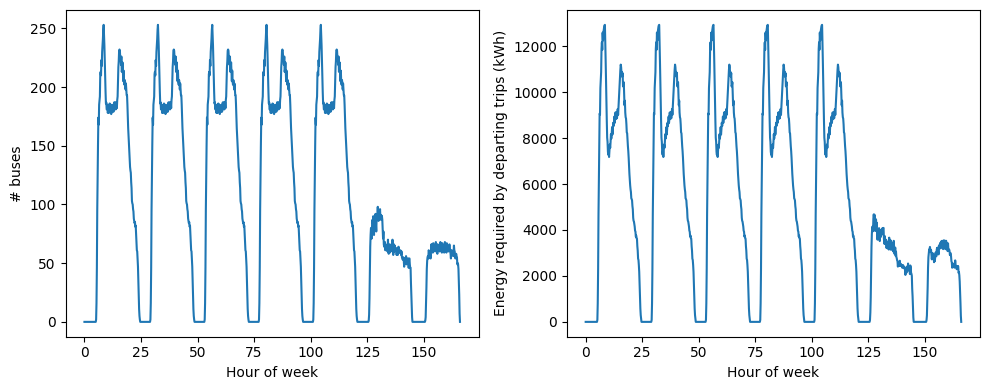

In [152]:

trips_data['passengers'] = 30

bus = ebus.Yutong()

# from RouteZero.bus import Bus as Ebus
# max_passengers = 70
# battery_capacity = 400      # kWh
# charging_rate = 200         # kW
# gross_mass = 18000          # kg

# # default parameters that they could optionally change
# charging_efficiency=0.9
# end_of_life_cap=0.8

# bus = Ebus(max_passengers, battery_capacity, charging_rate, gross_mass,
#               charging_efficiency=charging_efficiency, end_of_life_cap=end_of_life_cap)

prediction_pipe = PredictionPipe()

ec_km, ec_total = prediction_pipe.predict_worst_case(trips_data, bus)

times, buses_in_traffic, depart_trip_energy_reqs, return_trip_enery_consumed = calc_buses_in_traffic(trips_data,
                                                                                                     deadhead=DEADHEAD,
                                                                                                     resolution=RESOLUTION,
                                                                                                     trip_ec=ec_total)
t = np.cumsum(depart_trip_energy_reqs) - np.cumsum(return_trip_enery_consumed)
print("min requried buses = ", buses_in_traffic.max())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(times / 60, buses_in_traffic)
plt.xlabel('Hour of week')
plt.ylabel('# buses')

plt.subplot(1, 2, 2)
# plt.plot(times / 60, depart_trip_energy_reqs)
plt.plot(times/60, t)
# plt.plot(times/60, return_trip_enery_consumed, label="returning trips")
plt.xlabel("Hour of week")
plt.ylabel("Energy required by departing trips (kWh)")

plt.tight_layout()
# plt.show()



In [153]:
# plot on map
route_summaries = summarise_results(trips_data, ec_km, ec_total)

gdf = _create_gdf_of_value(route_summaries, shapes, window='6:00 - 9:30')

map_title = "Route Energy Consumption"
colorbar_str = 'energy per km'

m = _create_gdf_map(gdf, map_title, colorbar_str)
_folium_open(m, map_title + '.html')

In [154]:
grid_limit = 'optim'
# grid_limit = 3500
Q = 10000    # relative cost on grid limit, set to 0 if no cost

Specify a priority on keeping the bus batteries charged at all times. Priority specified by R.

Note, this cost conflicts with the others as it attempts to maximise the battery charge (i.e. acts against other objectives). Hence the relative weighting of R with respect to the other weightings/costs will greatly impact the results and there will be a fine line between it doing nothing and overriding the other objectives.

In [155]:
R = 0       # priority on bus charge

Specify battery if we would like to include one. If we would like to optimise the battery capacity, then set to 'optim'. 'cost' is the relative weighting on the battery capacity. 'cost' must be provided either way.

If set to 'optim' attempts to minimise the capacity using the relative weighting of 'cost'

In [156]:
battery = {'power':2000, 'capacity':4000, 'efficiency':0.95, 'cost':10}
# battery = {'power':1000, 'capacity':'optim', 'efficiency':0.95, 'cost':100}
# battery = {'power':0, 'capacity':0, 'efficiency':0.95, 'cost':10}
battery_specs = copy.deepcopy(battery)

Chargers

In [157]:
charger_power_array = [80, 150, 300] 
charger_cost_array = [1, 5, 20]
chargers = {'power': charger_power_array, 
            'number': ["optim", "optim", "optim"], 
            'cost': charger_cost_array}
charger_specs = copy.deepcopy(chargers)

Specified allowed times of day to charge (which hours), default is all

In [158]:
windows = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok

Set up the problem and optimise

In [159]:
problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=windows)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

Solve took 76.52666926383972 seconds


Plot results

Max grid power is 8307.7817 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([32.,  3.,  4.]), 'cost': [20, 5, 1]}
{'power': 2000, 'capacity': 4000, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 0.0 %


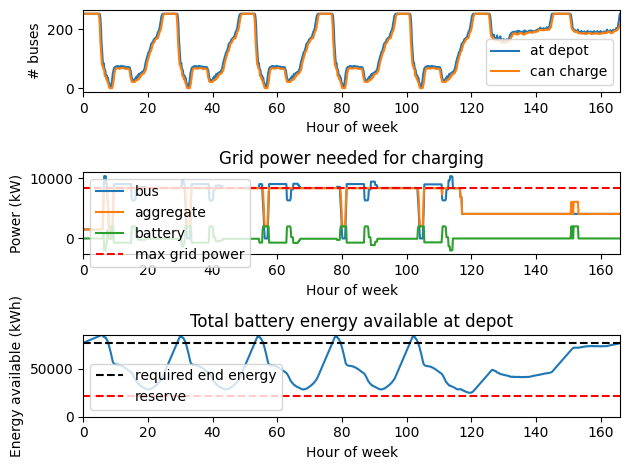

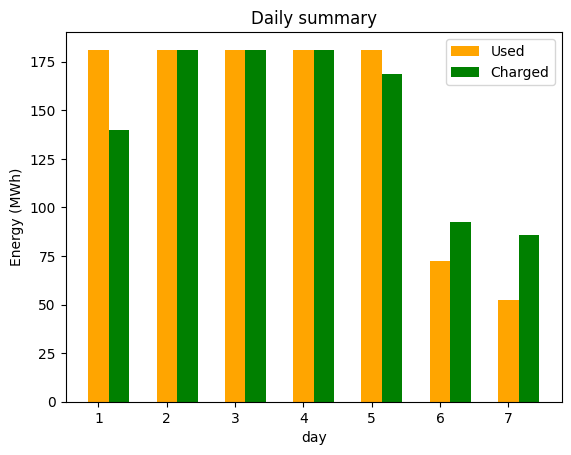

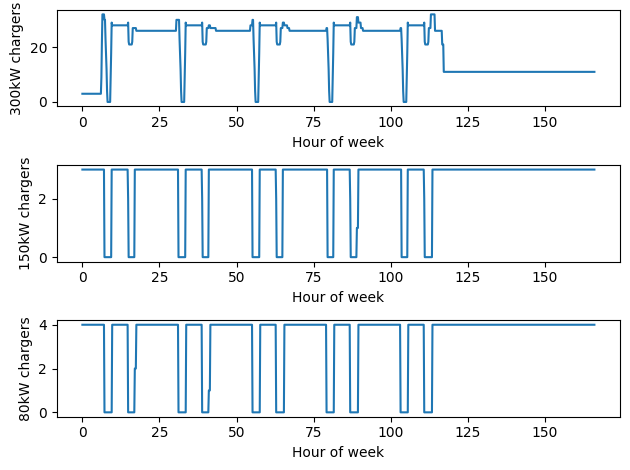

In [160]:
chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

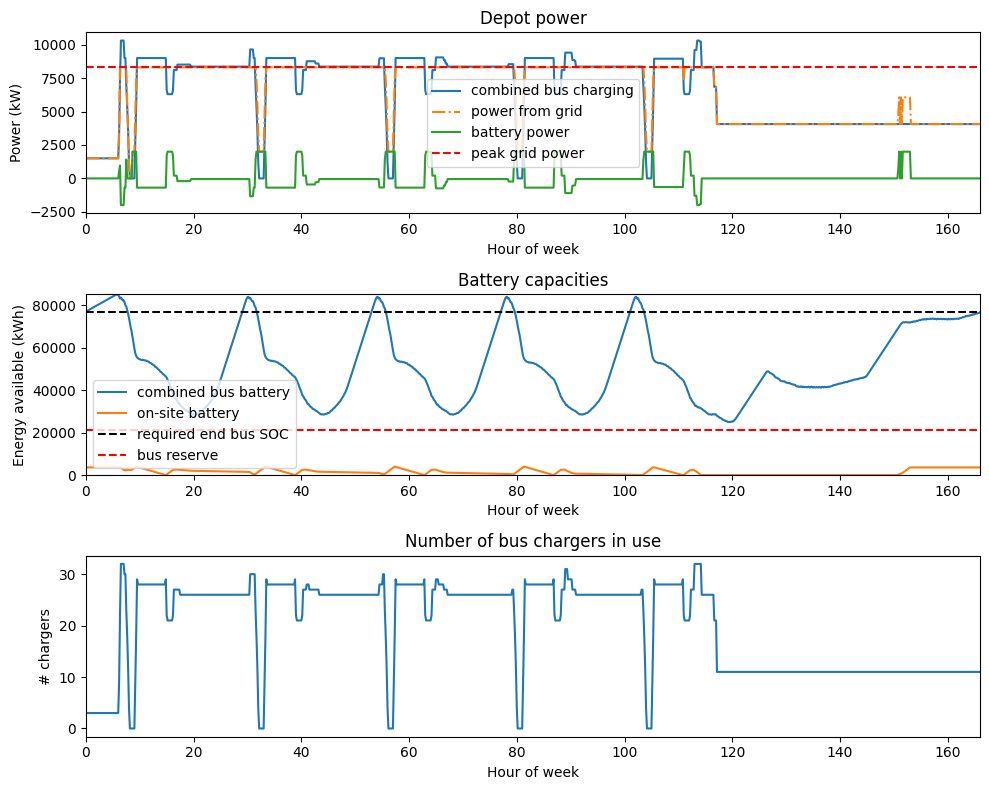

In [161]:
plot_study_results(results, problem)

Reference case without depot battery, leaving everything else the same

Solve took 72.81261444091797 seconds
Max grid power is 8307.7817 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([32.,  3.,  4.]), 'cost': [20, 5, 1]}
{'power': 2000, 'capacity': 4000, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 0.0 %


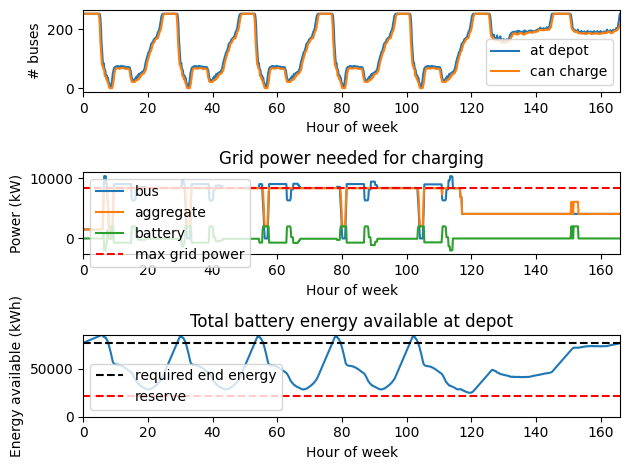

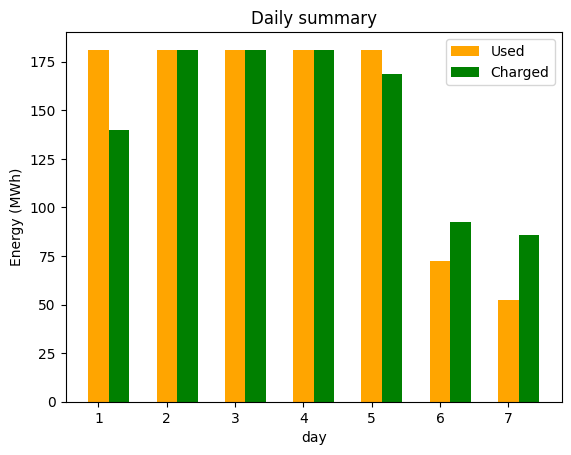

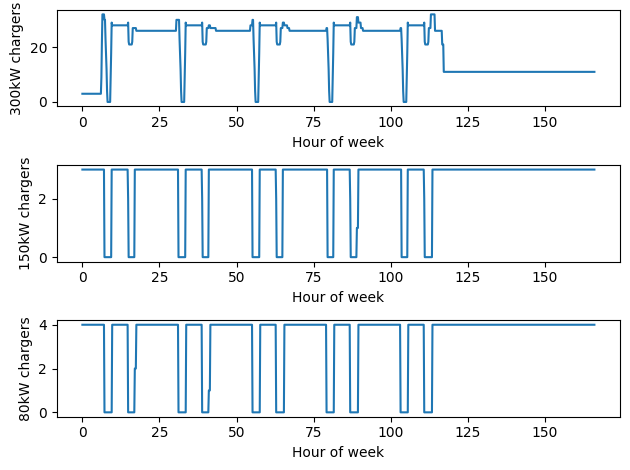

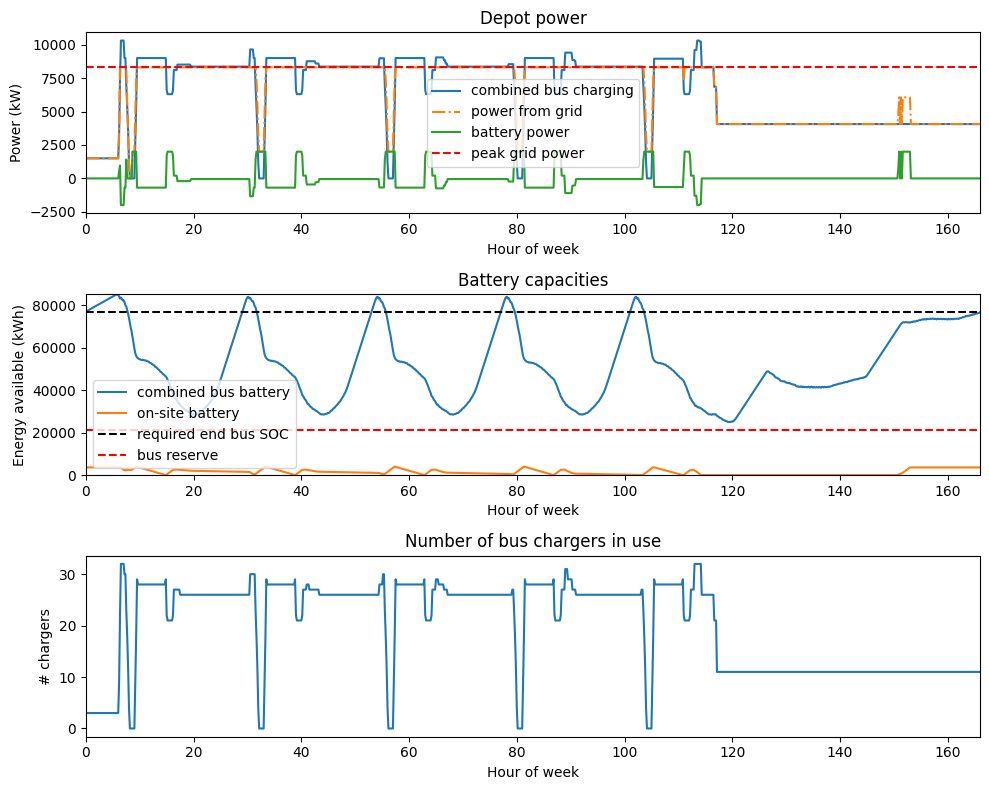

In [162]:

battery = copy.deepcopy(battery_specs)
chargers = copy.deepcopy(charger_specs)

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=windows)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)
plot_study_results(results, problem)

### Now investigate the effects of extra buses, chargers and depot batteries on peak power demand

Scan number of buses, charging at all times

In [163]:
nu_buses = 21
min_bus = 253
max_bus = 293

windows = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok

t1 = time.time()
scan_bus_peak_demands = []
scan_bus_chargers_required = []

Q = 10000
for num_bus in np.linspace(min_bus, max_bus, nu_buses):
    chargers = {'power': charger_power_array, 
            'number': ["optim", "optim", "optim"], 
            'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus)
    
    results = problem.solve()
    
    scan_bus_peak_demands.append(results['grid_limit'])
    scan_bus_chargers_required.append(chargers['number'])

print(scan_bus_peak_demands)
print(scan_bus_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[8307.7817, 8236.7246, 8173.5563, 8116.181, 8062.5476, 8013.6186, 7968.9652, 7928.9292, 7890.0959, 7855.3792, 7828.4063, 7820.3555, 7812.744, 7805.1478, 7800.2419, 7795.359, 7790.476, 7785.5931, 7780.7102, 7775.8273, 7770.9443]
[array([32.,  3.,  4.]), array([32.,  0.,  8.]), array([34.,  0.,  0.]), array([32.,  3.,  1.]), array([31.,  3.,  4.]), array([33.,  0.,  2.]), array([31.,  3.,  3.]), array([26.,  8., 12.]), array([25.,  5., 20.]), array([26.,  0., 22.]), array([24.,  4., 18.]), array([26.,  0., 10.]), array([25.,  2.,  5.]), array([26.,  0.,  1.]), array([25.,  1.,  3.]), array([22.,  8.,  1.]), array([20., 12.,  1.]), array([18., 16.,  1.]), array([16., 20.,  1.]), array([14., 24.,  1.]), array([12., 28.,  1.])]
Solve took 1797.5565257072449 seconds


Scan number of buses, charging outside peak times

In [164]:

windows = [1]*7 + [0]*3 + [1]*5 + [0]*5 + [1]*4     # peak times not allowed

t1 = time.time()
scan_bus_peak_demands_offpeak = []
scan_bus_chargers_required_offpeak = []
Q = 10000
for num_bus in np.linspace(min_bus, max_bus, nu_buses):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=windows)
    
    results = problem.solve()
    
    scan_bus_peak_demands_offpeak.append(results['grid_limit'])
    scan_bus_chargers_required_offpeak.append(chargers['number'])

print(scan_bus_peak_demands_offpeak)
print(scan_bus_chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[19176.923, 19270.745, 19049.668, 18842.323, 18634.978, 18443.868, 18258.745, 18092.422, 17935.339, 17778.256, 17621.174, 17464.091, 17330.904, 17199.928, 17089.987, 16983.376, 16876.765, 16770.155, 16663.544, 16556.934, 16450.323]
[array([68.,  0.,  0.]), array([66.,  2.,  2.]), array([62., 10.,  0.]), array([59., 14.,  0.]), array([56., 18.,  1.]), array([58.,  6., 14.]), array([60.,  0., 14.]), array([59.,  3., 10.]), array([56.,  8., 10.]), array([54.,  9., 14.]), array([56.,  0., 21.]), array([58.,  0., 11.]), array([56.,  4., 10.]), array([57.,  0., 12.]), array([55.,  4., 10.]), array([53.,  7., 11.]), array([50., 12., 11.]), array([47., 18., 10.]), array([45., 21., 11.]), array([42., 26., 11.]), array([39., 32., 10.])]
Solve took 903.8460936546326 seconds


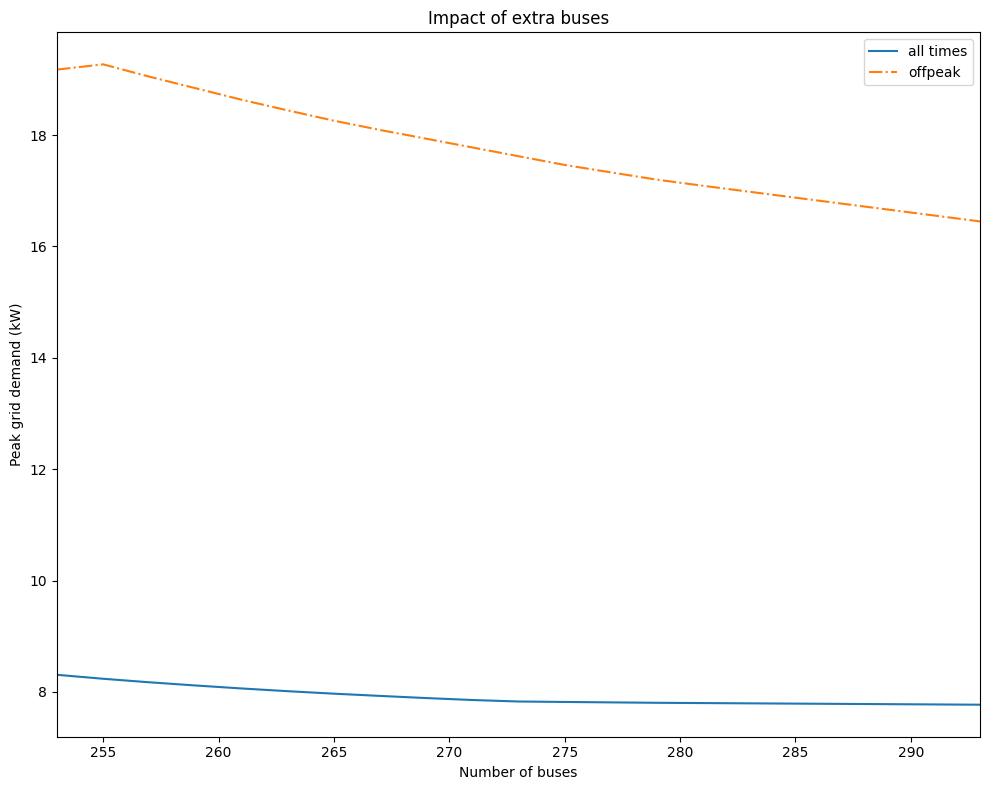

In [165]:
x_data = np.linspace(min_bus,max_bus,nu_buses)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_bus_peak_demands)/1000, label='all times')
plt.plot(x_data, np.array(scan_bus_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of extra buses')
plt.xlabel('Number of buses')
plt.ylabel('Peak grid demand (kW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()

Scan number of chargers, charging at all times

In [166]:
nu_chargers = 11
min_charger = 68
max_charger = 108

windows = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok

t1 = time.time()
scan_charger_peak_demands = []
scan_charger_chargers_required = []
Q = 10000
num_bus = 260
for c in np.linspace(min_charger,max_charger,nu_chargers):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", int(c)], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=windows)
    
    results = problem.solve()
    
    scan_charger_peak_demands.append(results['grid_limit'])
    scan_charger_chargers_required.append(chargers['number'])

print(scan_charger_peak_demands)
print(scan_charger_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[8089.3252, 8089.3252, 8089.3252, 8089.3252, 8089.3252, 8089.3252, 8089.3252, 8089.3252, 8089.3252, 8089.3252, 8089.3252]
[array([68.,  0.,  0.]), array([72.,  0.,  0.]), array([76.,  0.,  0.]), array([80.,  0.,  0.]), array([84.,  0.,  0.]), array([88.,  0.,  0.]), array([92.,  0.,  0.]), array([96.,  0.,  0.]), array([100.,   0.,   0.]), array([104.,   0.,   0.]), array([108.,   0.,   0.])]
Solve took 656.2131726741791 seconds


Scan number of chargers, charging outside peak times

In [167]:
windows = [1]*7 + [0]*3 + [1]*5 + [0]*5 + [1]*4     # peak times not allowed

t1 = time.time()
scan_charger_peak_demands_offpeak = []
scan_charger_chargers_required_offpeak = []
Q = 10000
num_bus = 260
for c in np.linspace(min_charger,max_charger,nu_chargers):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", int(c)], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=windows)
    
    results = problem.solve()
    
    scan_charger_peak_demands_offpeak.append(results['grid_limit'])
    scan_charger_chargers_required_offpeak.append(chargers['number'])

print(scan_charger_peak_demands_offpeak)
print(scan_charger_chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[18738.651, 18738.651, 18738.651, 18738.651, 18738.651, 18738.651, 18738.651, 18738.651, 18738.651, 18738.651, 18738.651]
[array([68.,  0.,  0.]), array([72.,  0.,  0.]), array([76.,  0.,  0.]), array([80.,  0.,  0.]), array([84.,  0.,  0.]), array([88.,  0.,  0.]), array([92.,  0.,  0.]), array([96.,  0.,  0.]), array([100.,   0.,   0.]), array([104.,   0.,   0.]), array([108.,   0.,   0.])]
Solve took 387.27298045158386 seconds


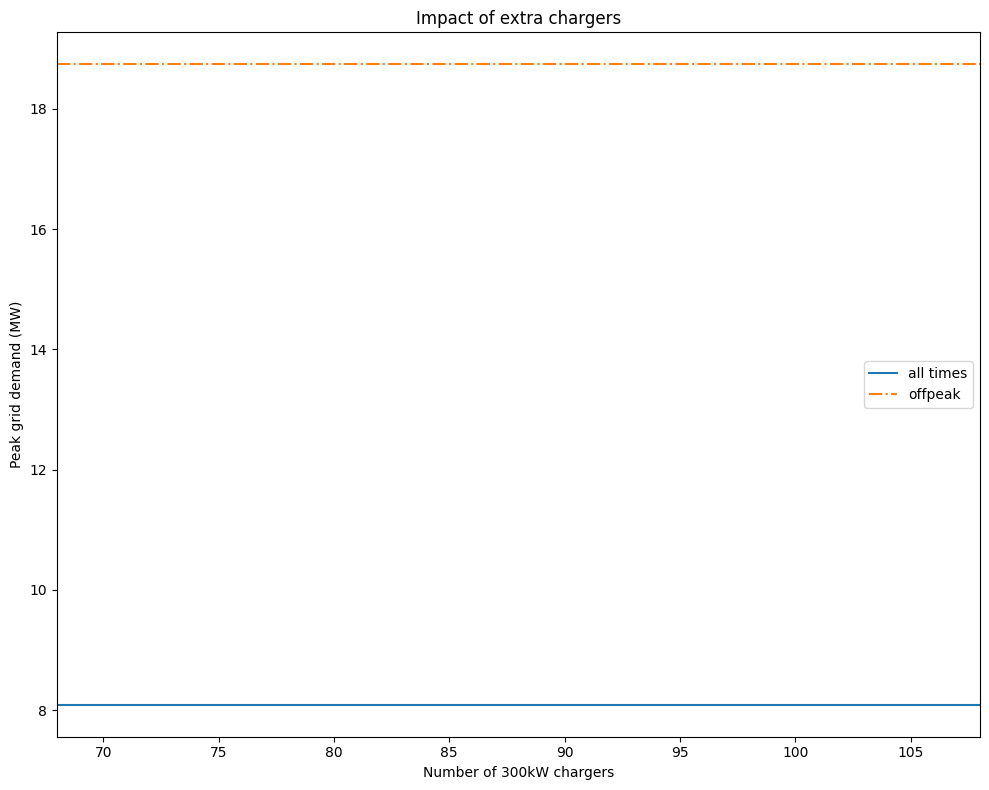

In [168]:
x_data = np.linspace(min_charger,max_charger,nu_chargers)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_charger_peak_demands)/1000, label='all times')
plt.plot(x_data, np.array(scan_charger_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of extra chargers')
plt.xlabel('Number of 300kW chargers')
plt.ylabel('Peak grid demand (MW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()

Scan battery capacities, charging at all times

In [169]:
nu_batteries = 21
min_battery = 0
max_battery = 10000

windows = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok

t1 = time.time()
scan_battery_peak_demands = []
scan_battery_chargers_required = []
Q = 10000
num_bus = 260
batt_c_rating = 2
for batt_p in np.linspace(min_battery,max_battery,nu_batteries):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}
    
    battery = {'power':batt_p, 'capacity':batt_p*batt_c_rating, 'efficiency':0.95, 'cost':10}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=windows)
    
    results = problem.solve()
    
    scan_battery_peak_demands.append(results['grid_limit'])
    scan_battery_chargers_required.append(chargers['number'])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[8264.2346, 8215.8096, 8171.6221, 8130.4737, 8089.3252, 8049.3857, 8012.961, 7979.6881, 7947.9622, 7916.2364, 7886.9572, 7858.3625, 7839.0764, 7830.0675, 7821.0587, 7812.0498, 7803.0409, 7794.0321, 7785.0232, 7776.0143, 7767.0055]
[array([28.,  0.,  0.]), array([29.,  0.,  1.]), array([30.,  0.,  3.]), array([30.,  2.,  5.]), array([31.,  5.,  1.]), array([34.,  2.,  1.]), array([37.,  0.,  0.]), array([37.,  0.,  5.]), array([37.,  1.,  9.]), array([37.,  8.,  2.]), array([39.,  8.,  0.]), array([43.,  2.,  2.]), array([46.,  0.,  1.]), array([46.,  0.,  1.]), array([46.,  0.,  1.]), array([46.,  0.,  1.]), array([46.,  0.,  1.]), array([46.,  0.,  1.]), array([46.,  0.,  1.]), array([46.,  0.,  1.]), array([46.,  0.,  1.])]
Solve took 1721.226125240326 seconds


Scan battery capacities, charging outside peak times

In [170]:
windows = [1]*7 + [0]*3 + [1]*5 + [0]*5 + [1]*4     # peak times not allowed

t1 = time.time()
scan_battery_peak_demands_offpeak = []
chargers_required_offpeak = []
Q = 10000
num_bus = 260
batt_c_rating = 2
for batt_p in np.linspace(min_battery,max_battery,nu_batteries):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}
    
    battery = {'power':batt_p, 'capacity':batt_p*batt_c_rating, 'efficiency':0.95, 'cost':10}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=windows)
    
    results = problem.solve()
    
    scan_battery_peak_demands_offpeak.append(results['grid_limit'])
    chargers_required_offpeak.append(chargers['number'])

print(scan_battery_peak_demands_offpeak)
print(chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[19583.095, 19371.984, 19160.873, 18949.762, 18738.651, 18527.54, 18316.429, 18105.317, 17894.206, 17683.095, 17471.984, 17260.873, 17049.762, 16838.651, 16627.54, 16419.413, 16215.842, 16012.27, 15808.699, 15605.127, 15401.556]
[array([63.,  5.,  0.]), array([62.,  5.,  3.]), array([60.,  8.,  6.]), array([59., 11.,  4.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.]), array([57., 18.,  0.])]
Solve took 1062.3118000030518 seconds


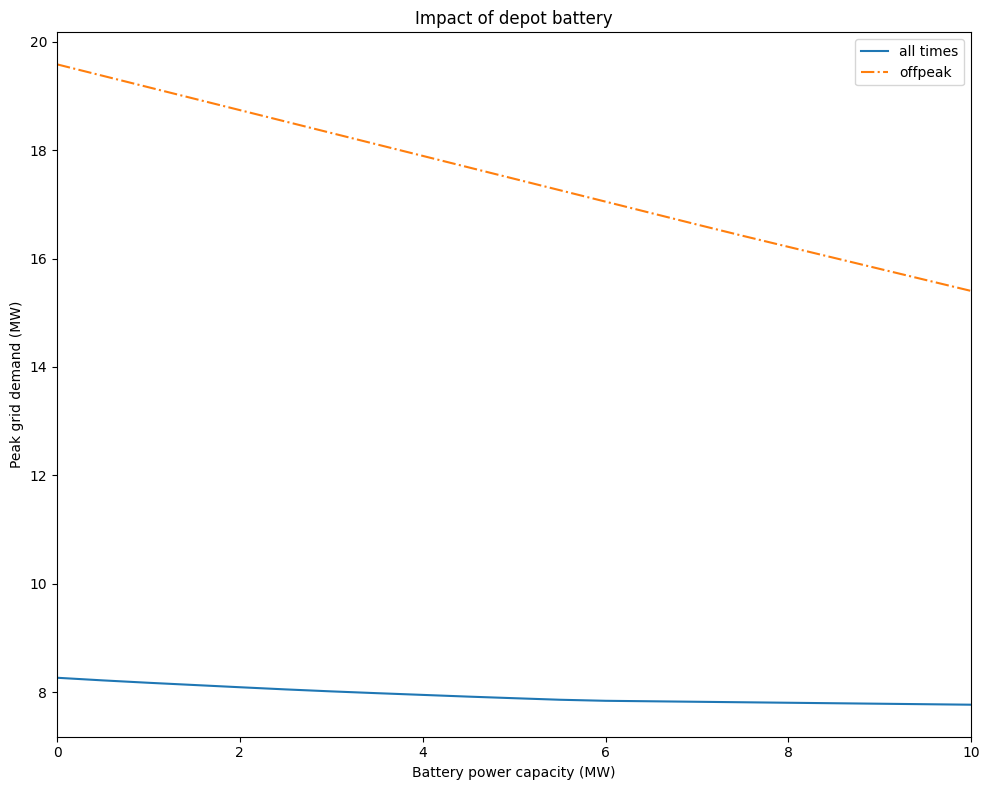

In [171]:
x_data = np.linspace(min_battery/1000,max_battery/1000,nu_batteries)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_battery_peak_demands)/1000, label='all times')
plt.plot(x_data, np.array(scan_battery_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of depot battery')
plt.xlabel('Battery power capacity (MW)')
plt.ylabel('Peak grid demand (MW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()



In [172]:
nu_battery_powers = 11
min_battery_p = 0
max_battery_p = 10 #MW
batt_ps = np.linspace(min_battery_p,max_battery_p,nu_battery_powers)
nu_battery_capacities = 21
min_battery_c = 0
max_battery_c = 50 #MW
batt_cs = np.linspace(min_battery_c,max_battery_c,nu_battery_capacities)

windows = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok

t1 = time.time()
scan_battery_peak_demands = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
Q = 10000
num_bus = 260
for batt_p in batt_ps:
    for batt_c in batt_cs:
        chargers = {'power': charger_power_array, 
                    'number': ["optim", "optim", "optim"], 
                    'cost': charger_cost_array}
        
        battery = {'power':batt_p*1000, 'capacity':batt_c*1000, 'efficiency':0.95, 'cost':10}

        problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                            start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                            resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                            reserve=RESERVE, battery=battery, num_buses=num_bus,
                            windows=windows)
        
        results = problem.solve()
        
        scan_battery_peak_demands.loc[batt_p, batt_c] = float(results['grid_limit'])
        scan_battery_chargers_required.loc[batt_p, batt_c] = float(chargers['number'][0])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

           0.0        2.5        5.0        7.5        10.0       12.5  \
0.0   8264.2346  8264.2346  8264.2346  8264.2346  8264.2346  8264.2346   
1.0   8264.2346  8166.9208  8143.4145  8119.9082  8096.4019  8072.8956   
2.0   8264.2346  8124.0246  8079.9227  8056.4164  8032.9101  8009.4038   
3.0   8264.2346  8121.7346  8022.3387  7998.8946  7975.4505  7952.0065   
4.0   8264.2346  8121.7346  7993.1615  7952.6387  7929.2565  7905.8744   
5.0   8264.2346  8121.7346  7989.8002  7910.2016  7886.9572  7863.7128   
6.0   8264.2346  8121.7346  7987.0287  7879.6163  7857.0941  7834.5720   
7.0   8264.2346  8121.7346  7987.0287  7879.6163  7857.0941  7834.5720   
8.0   8264.2346  8121.7346  7987.0287  7879.6163  7857.0941  7834.5720   
9.0   8264.2346  8121.7346  7987.0287  7879.6163  7857.0941  7834.5720   
10.0  8264.2346  8121.7346  7987.0287  7879.6163  7857.0941  7834.5720   

           15.0       17.5       20.0       22.5  ...       27.5       30.0  \
0.0   8264.2346  8264.2346  8264

Text(0, 0.5, 'Number of chargers')

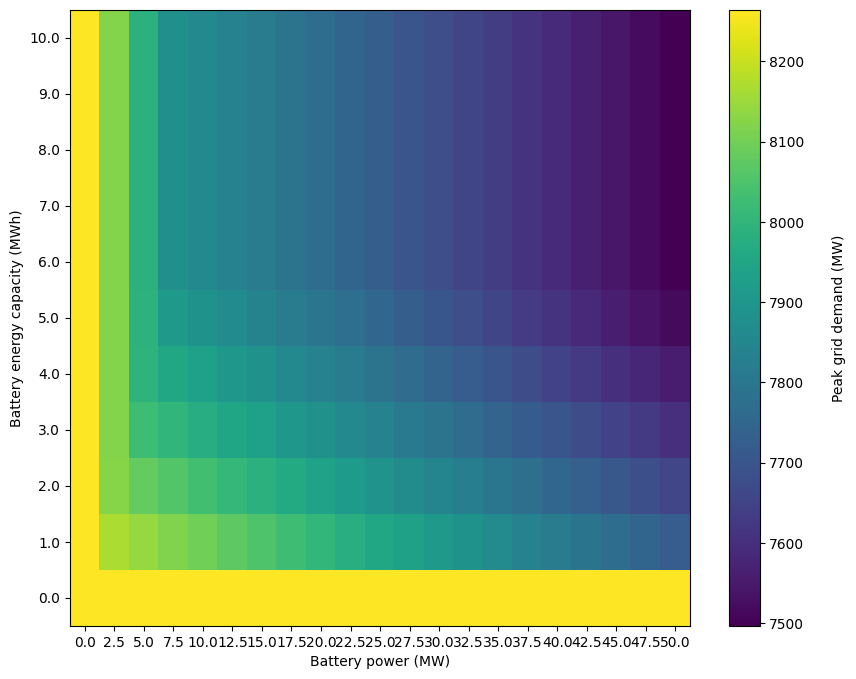

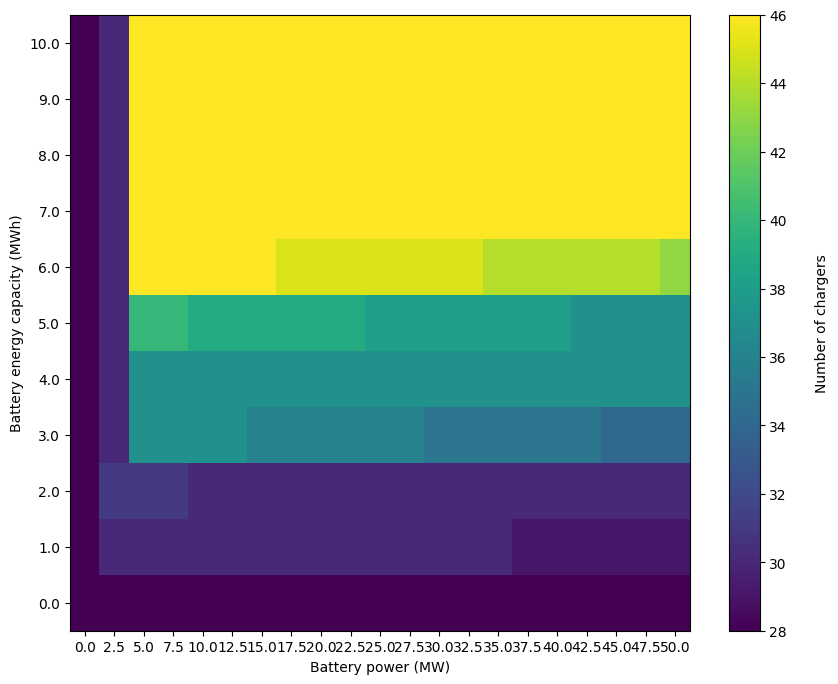

In [173]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_peak_demands)
plt.yticks(np.arange(0.5, len(scan_battery_peak_demands.index), 1), scan_battery_peak_demands.index)
plt.xticks(np.arange(0.5, len(scan_battery_peak_demands.columns), 1), scan_battery_peak_demands.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Peak grid demand (MW)", labelpad=20)#, rotation=270)

fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_chargers_required)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required.index), 1), scan_battery_chargers_required.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required.columns), 1), scan_battery_chargers_required.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of chargers", labelpad=20)#, rotation=270)

In [174]:
windows = [1]*7 + [0]*3 + [1]*5 + [0]*5 + [1]*4     # peak times not allowed

t1 = time.time()
scan_battery_peak_demands = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
Q = 10000
num_bus = 260
for batt_p in batt_ps:
    for batt_c in batt_cs:
        chargers = {'power': charger_power_array, 
                    'number': ["optim", "optim", "optim"], 
                    'cost': charger_cost_array}
        
        battery = {'power':batt_p*1000, 'capacity':batt_c*1000, 'efficiency':0.95, 'cost':10}

        problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                            start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                            resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                            reserve=RESERVE, battery=battery, num_buses=num_bus,
                            windows=windows)
        
        results = problem.solve()
        
        scan_battery_peak_demands.loc[batt_p, batt_c] = float(results['grid_limit'])
        scan_battery_chargers_required.loc[batt_p, batt_c] = float(chargers['number'][0])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

           0.0        2.5        5.0        7.5        10.0       12.5  \
0.0   19583.095  19583.095  19583.095  19583.095  19583.095  19583.095   
1.0   19583.095  19055.317  18583.095  18583.095  18583.095  18583.095   
2.0   19583.095  19055.317  18527.540  17999.762  17583.095  17583.095   
3.0   19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   
4.0   19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   
5.0   19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   
6.0   19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   
7.0   19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   
8.0   19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   
9.0   19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   
10.0  19583.095  19055.317  18527.540  17999.762  17471.984  16944.206   

           15.0       17.5       20.0       22.5  ...       27.5       30.0  \
0.0   19583.095  19583.095  1958

Text(0, 0.5, 'Number of chargers')

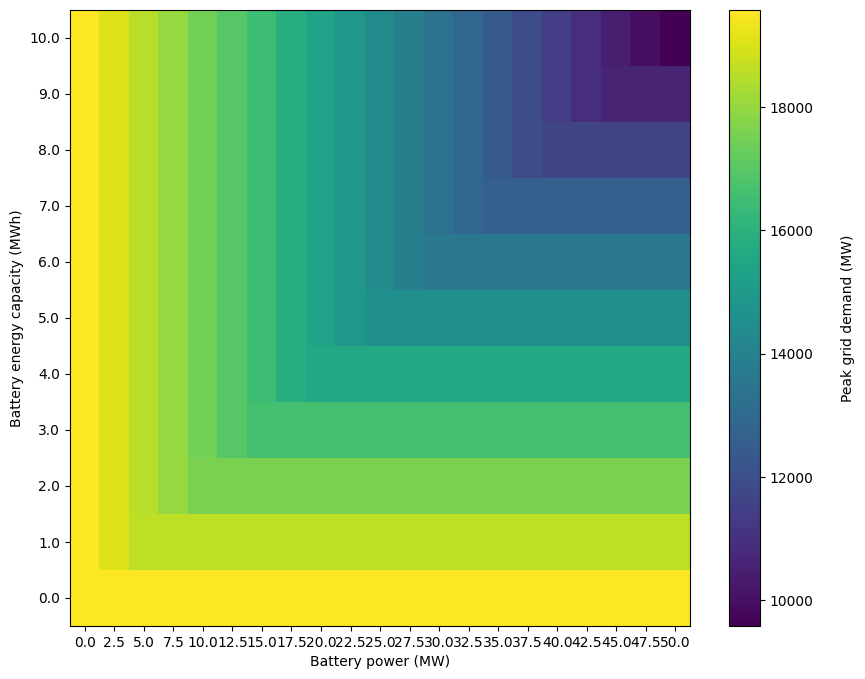

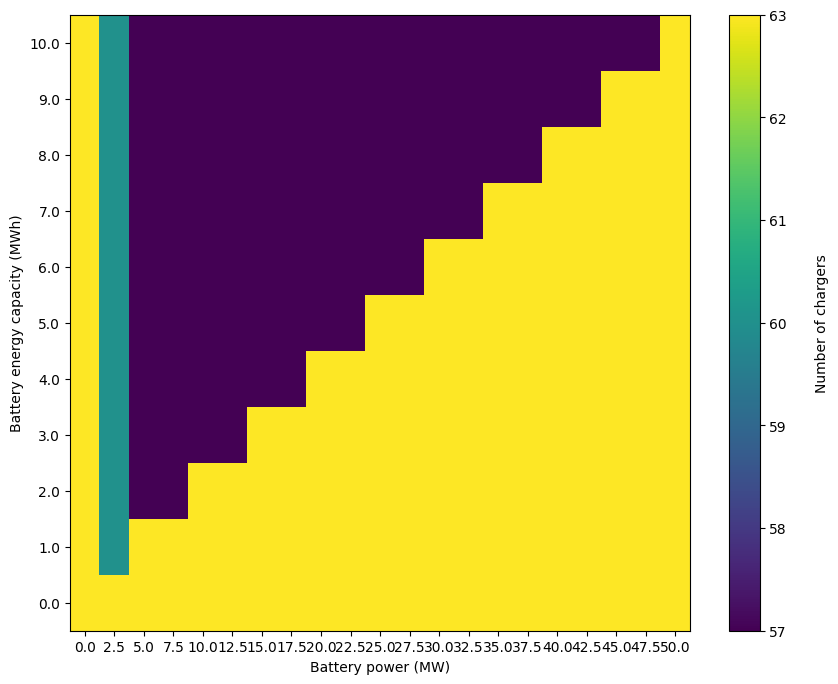

In [175]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_peak_demands)
plt.yticks(np.arange(0.5, len(scan_battery_peak_demands.index), 1), scan_battery_peak_demands.index)
plt.xticks(np.arange(0.5, len(scan_battery_peak_demands.columns), 1), scan_battery_peak_demands.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Peak grid demand (MW)", labelpad=20)#, rotation=270)

fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_chargers_required)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required.index), 1), scan_battery_chargers_required.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required.columns), 1), scan_battery_chargers_required.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of chargers", labelpad=20)#, rotation=270)